# Visualize

In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_path = "/kaggle/input/cardiac-images-masks-plosone/Images/frame_1.jpg"
json_path = "/kaggle/input/cardiac-images-masks-plosone/MasksJsonContours/mascara1.json"

In [3]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
with open(json_path, "r") as f:
    masks = json.load(f)

In [5]:
overlay_image = image.copy()

In [6]:
colors = {
    "LV": (255, 0, 0),   # Red
    "LA": (0, 255, 0),   # Green
    "RV": (0, 0, 255),   # Blue
    "RA": (255, 255, 0)  # Yellow
}


In [7]:
h, w, _ = image.shape
print(f"Image size: {w}x{h}")

Image size: 128x128


In [8]:
for chamber, points in masks.items():
    points = np.array([(x, y) for y, x in points], np.int32) 
    points = points.reshape((-1, 1, 2))  
    cv2.polylines(overlay_image, [points], isClosed=True, color=colors[chamber], thickness=2)


    for (x, y) in points[:, 0]:
        cv2.circle(overlay_image, (x, y), 2, colors[chamber], -1)

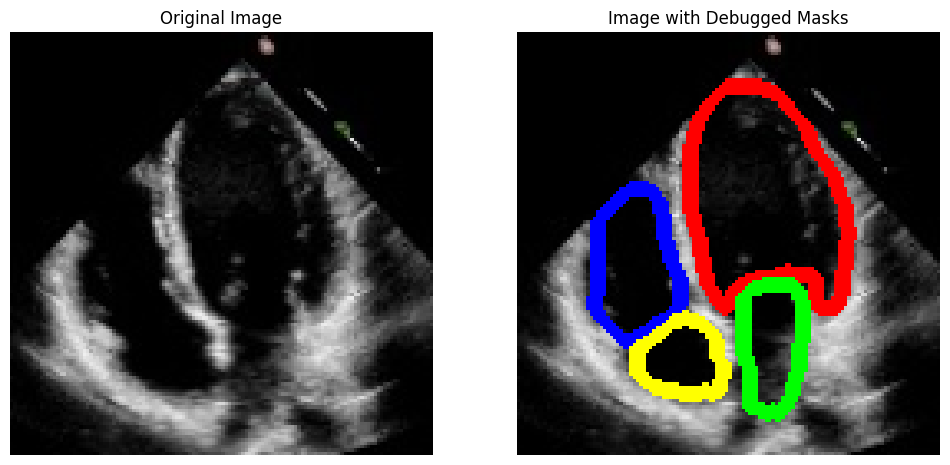

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(overlay_image)
ax[1].set_title("Image with Debugged Masks")
ax[1].axis("off")

plt.show()


# Training

In [10]:
!pip install segmentation-models-pytorch torch torchvision albumentations --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 5.7 MB/s eta 0:00:00


In [11]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from glob import glob

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [12]:
class HeartSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg"))) 
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.json")))  
        self.transform = transform
        self.chamber_mapping = {"LV": 1, "LA": 2, "RV": 3, "RA": 4}  
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)  
        img = cv2.resize(img, (256, 256))  

        # Load mask
        with open(self.mask_paths[idx], "r") as f:
            masks = json.load(f)

        mask = np.zeros((256, 256), dtype=np.uint8)

        for chamber, points in masks.items():
            if chamber not in self.chamber_mapping:
                continue  
            
            class_id = self.chamber_mapping[chamber]

            points = np.array([(x, y) for y, x in points], np.int32)

            points = points.reshape((-1, 1, 2))

            points = (points * (256 / 128)).astype(np.int32)

            cv2.fillPoly(mask, [points], class_id)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]

        return img, torch.tensor(mask, dtype=torch.long)

In [13]:
transform = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),  
    ToTensorV2()
])

In [14]:
image_dir = "/kaggle/input/cardiac-images-masks-plosone/Images"
mask_dir = "/kaggle/input/cardiac-images-masks-plosone/MasksJsonContours"

In [15]:
dataset = HeartSegmentationDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

<ipython-input-12-c7f78dc5c8f5>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask, dtype=torch.long)


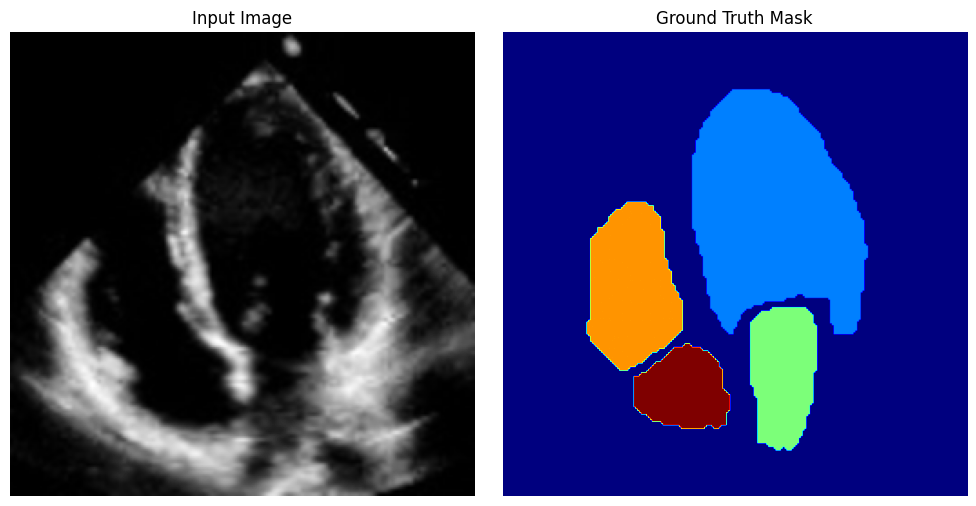

In [16]:
img, mask = dataset[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].imshow(img.squeeze(), cmap="gray")
axes[0].set_title("Input Image")
axes[0].axis("off")  


axes[1].imshow(mask, cmap="jet")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")  

plt.tight_layout()  
plt.show()


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
model = smp.Unet(
    encoder_name="resnet34",  
    encoder_weights="imagenet",  
    in_channels=1,  
    classes=5,  
).to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 191MB/s]


In [19]:
dice_loss = smp.losses.DiceLoss(mode="multiclass")
ce_loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [20]:
num_epochs = 250

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
    
        outputs = model(images)
    
        loss = dice_loss(outputs, masks) + ce_loss(outputs, masks)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


<ipython-input-12-c7f78dc5c8f5>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask, dtype=torch.long)


Epoch 1/250, Loss: 28.5149
Epoch 2/250, Loss: 22.1462
Epoch 3/250, Loss: 19.1492
Epoch 4/250, Loss: 17.2239
Epoch 5/250, Loss: 15.7651
Epoch 6/250, Loss: 14.5184
Epoch 7/250, Loss: 13.4131
Epoch 8/250, Loss: 12.3764
Epoch 9/250, Loss: 11.4335
Epoch 10/250, Loss: 10.5858
Epoch 11/250, Loss: 9.8040
Epoch 12/250, Loss: 9.0542
Epoch 13/250, Loss: 8.4081
Epoch 14/250, Loss: 7.8014
Epoch 15/250, Loss: 7.2510
Epoch 16/250, Loss: 6.7300
Epoch 17/250, Loss: 6.2713
Epoch 18/250, Loss: 5.9073
Epoch 19/250, Loss: 5.5006
Epoch 20/250, Loss: 5.1196
Epoch 21/250, Loss: 4.7589
Epoch 22/250, Loss: 4.4237
Epoch 23/250, Loss: 4.1802
Epoch 24/250, Loss: 3.9360
Epoch 25/250, Loss: 3.7259
Epoch 26/250, Loss: 3.5037
Epoch 27/250, Loss: 3.2874
Epoch 28/250, Loss: 3.1294
Epoch 29/250, Loss: 2.9572
Epoch 30/250, Loss: 2.8094
Epoch 31/250, Loss: 2.6709
Epoch 32/250, Loss: 2.5274
Epoch 33/250, Loss: 2.4273
Epoch 34/250, Loss: 2.3200
Epoch 35/250, Loss: 2.2264
Epoch 36/250, Loss: 2.1141
Epoch 37/250, Loss: 2.0300


In [21]:
model.eval()
with torch.no_grad():
    img, mask = dataset[0]  
    img = img.unsqueeze(0).to(device)  
    pred_mask = model(img)  
    pred_mask = torch.argmax(pred_mask.squeeze(), dim=0).cpu().numpy()
    

<ipython-input-12-c7f78dc5c8f5>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask, dtype=torch.long)


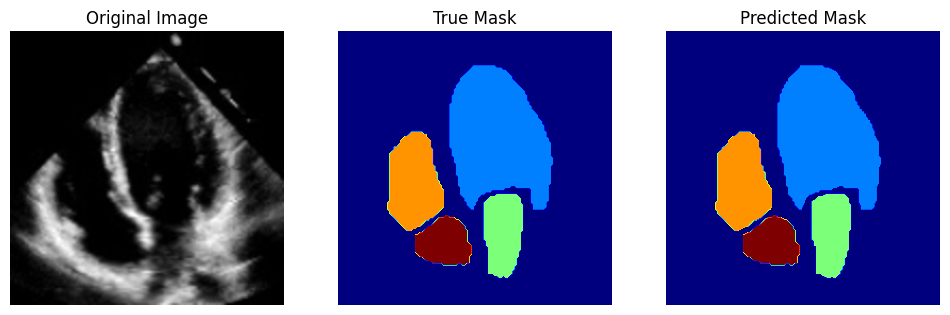

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(img.squeeze().cpu(), cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask.cpu(), cmap="jet")
ax[1].set_title("True Mask")
ax[1].axis("off")

ax[2].imshow(pred_mask, cmap="jet")
ax[2].set_title("Predicted Mask")
ax[2].axis("off")

plt.show()

In [23]:
model_path = "unet_heart_segmentation.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to unet_heart_segmentation.pth


In [24]:
model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=1, classes=5)
model.load_state_dict(torch.load("unet_heart_segmentation.pth"))
model.to(device)
model.eval() 

<ipython-input-24-16f8aa274e7c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_heart_segmentation.pth"))


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [25]:
video_path = "/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X10267ADF2E644E0.avi"
cap = cv2.VideoCapture(video_path)

In [26]:
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [27]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

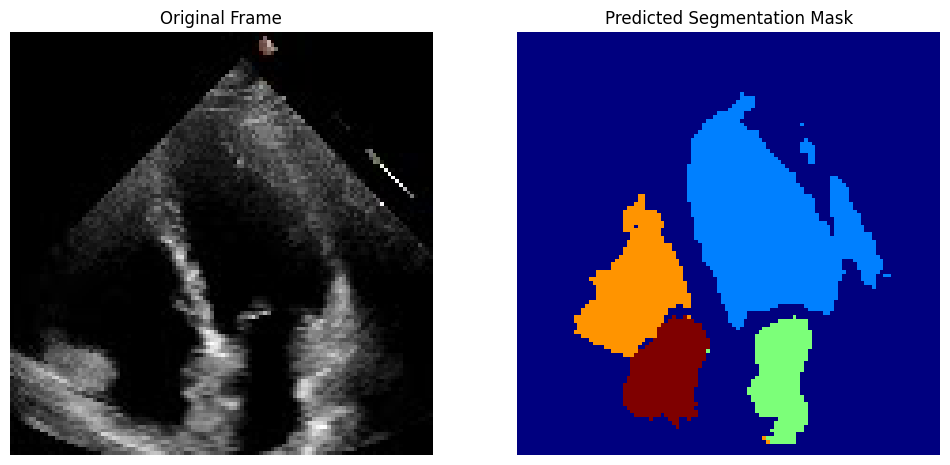

In [28]:
ret, frame = cap.read()
cap.release()  

if ret:
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    input_tensor = transform(gray_frame).unsqueeze(0).to(device) 

    with torch.no_grad():
        output = model(input_tensor) 
        pred_mask = torch.argmax(output, dim=1).cpu().numpy()[0]  
    h, w = frame.shape[:2]
    pred_mask = cv2.resize(pred_mask.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) 
    ax[0].set_title("Original Frame")
    ax[0].axis("off")

    ax[1].imshow(pred_mask, cmap="jet")  
    ax[1].set_title("Predicted Segmentation Mask")
    ax[1].axis("off")

    plt.show()